<a href="https://colab.research.google.com/github/KNL1979/DS807/blob/main/Q2_variational_autoencoder_VAE4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational autoencoder model VAE4

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# path to file
%cd '/content/gdrive/MyDrive/Applied_ML'

/content/gdrive/MyDrive/Applied_ML


In [ ]:
# Load the training data features
X_train = np.load('eksamen/dataset/X_train_new.npy')
X_val = np.load('eksamen/dataset/X_val_new.npy')
X_test = np.load('eksamen/dataset/X_test_new.npy')
print(f'Shape of the training data: {X_train.shape}')
print(f'Shape of the validataion data: {X_val.shape}')
print(f'Shape of the test data: {X_test.shape}')

Shape of the training data: (55050, 96, 96, 3)
Shape of the validataion data: (15729, 96, 96, 3)
Shape of the test data: (7864, 96, 96, 3)


In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(16)

In [ ]:
# check the dimensions of the dataset
batch1 = next(iter(train_dataset.take(1)))
print("Shape of features:", batch1.shape)

Shape of features: (16, 96, 96, 3)


In [ ]:
# create VAE class
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x):
        params = self.encoder(x)
        return tf.split(params, num_or_size_splits=2, axis=1) # mean, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return tf.sigmoid(self.decode(eps))

In [ ]:
# loss function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    vals = -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)

    return tf.reduce_sum(vals, axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [ ]:
# Train step function
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
# Function to show progress
def generate_and_show_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.show()

In [ ]:
# set latent dimension
latent_dim = 512

In [ ]:
# encoder architecture
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 3, 2, activation='relu', padding='same', input_shape=(96, 96, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Conv2D(128, 3, 2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Conv2D(256, 3, 2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Conv2D(512, 3, 2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2 * latent_dim), # 2 since we encode mean and standard deviation
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 spatial_dropout2d (Spatial  (None, 48, 48, 64)        0         
 Dropout2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       512       
 chNormalization)                                                
                                                        

In [ ]:
# decoder architecture
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=6*6*512, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Reshape(target_shape=(6, 6, 512)), # To get in "image format"
    tf.keras.layers.Conv2DTranspose(512, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Conv2DTranspose(256, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Conv2DTranspose(128, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Conv2DTranspose(3, 3, 1, padding='same'),
])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 18432)             9455616   
                                                                 
 reshape (Reshape)           (None, 6, 6, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 12, 12, 512)       2359808   
 anspose)                                                        
                                                                 
 batch_normalization_4 (Bat  (None, 12, 12, 512)       2048      
 chNormalization)                                                
                                                                 
 spatial_dropout2d_4 (Spati  (None, 12, 12, 512)       0         
 alDropout2D)                                                    
                                                      

In [ ]:
# build model
model = VAE(latent_dim, encoder, decoder)
optimizer = tf.keras.optimizers.Adam(1e-4)
test_sample = next(iter(train_dataset.take(1)))[:16]

In [ ]:
# fit model
loss_value = []

for epoch in range(20):
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)

    loss = tf.keras.metrics.Mean()
    for val_x in val_dataset:
        loss(compute_loss(model, val_x))
    variational_lower_bound = -loss.result()

    loss_value.append(variational_lower_bound)

    print(f'Epoch: {epoch}, Test set variational lower bound: {variational_lower_bound}')
    generate_and_show_images(model, epoch, test_sample)

In [ ]:
# save weights from the decoder - must be used for reconstruction of images as preprocessing during classification
decoder.save_weights('VAE_decoder_weights.h5')

In [ ]:
# use test dataset to predict the reconstucted images. These are in the following code used to calculate PSNR and MSE
test_sample = X_test

predicted = []

def generate_images(model, test_sample, batch_size=32, max_predictions=None):
    num_samples = len(test_sample)
    if max_predictions is not None:
        num_samples = min(num_samples, max_predictions)

    for i in range(0, num_samples, batch_size):
        batch = test_sample[i:i + batch_size]

        mean, logvar = model.encode(batch)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)

        for j in range(predictions.shape[0]):
            predicted.append(predictions[j])

# Generate images
generate_images(model, test_sample, batch_size=32, max_predictions=None)

# Check the length of the predicted list
print(len(predicted))

7864


In [ ]:
# test size
predicted_new= np.array(predicted)
print(predicted_new.shape)

(7864, 96, 96, 3)


In [ ]:
# find mean squared error between the original images and the images in the test set
def mse_reconstruction(reconstructed):
  mse_reconstruction = np.mean(np.square(reconstructed - X_test))
  return mse_reconstruction

In [ ]:
# Peak signal to noise ratio function
from math import log10

def PSNR(original, reconstructed):
  PSNR_list = []
  # set max to 1 (the highes intensity for a pixel), calculate Mean Square Error and Peak signal-to-noise-ratio
  MAX = 1
  MSE = np.mean((original.astype('float') - reconstructed.astype('float'))**2)
  PSNR = 20 * log10(MAX/(MSE**0.5))

  return PSNR

In [ ]:
# Find Peak signal-to-noise Ratio (PSNR) and mean squared error (MSE)
def PSNR_MSE(reconstructed):

  PSNR_list = []
  for ori, recon in zip(X_test, reconstructed):
    PSNR_value = PSNR(ori, recon)
    PSNR_list.append(PSNR_value)

  plt.hist(PSNR_list, bins=30, edgecolor='black')
  plt.show

  PSNR_mean = np.mean(PSNR_list)
  PSNR_std = np.std(PSNR_list)

  mse = mse_reconstruction(reconstructed)

  return PSNR_mean, PSNR_std, mse

(17.133533315390142, 3.1319516037607045, 0.023497606)

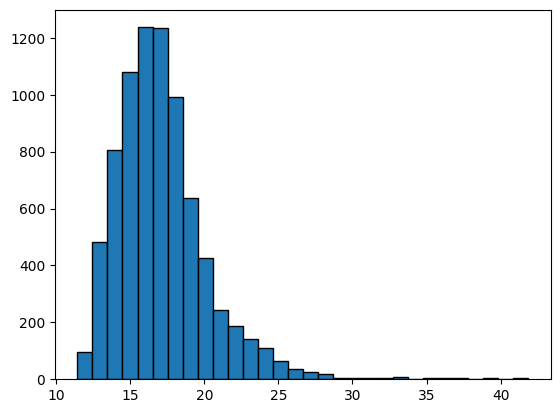

In [ ]:
PSNR_MSE(predicted_new)

In [ ]:
# predict the first images in X_val for visualization of images
model = VAE(latent_dim, encoder, decoder)
optimizer = tf.keras.optimizers.Adam(1e-4)
test_sample = X_val[:16]

predicted = []

def generate_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    for i in range(predictions.shape[0]):
        predicted.append(predictions[i:i+1])  # Append each prediction separately

# Call the function to generate images
generate_images(model, epoch, test_sample)


In [ ]:
# Create a 2x8 subplot grid and display images
fig, axs = plt.subplots(2, 8, figsize=(16, 4))

for i in range(16):
    row = i // 8
    col = i % 8

    axs[row, col].imshow(predicted[i][0, :, :, :])
    #axs[row, col].set_title(f"Image {i+1}")
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
minival = X_val[:16]

for i in range(16):
    row = i // 8
    col = i % 8

    axs[row, col].imshow(minival[i])
    #axs[row, col].set_title(f"Image {i+1}")
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

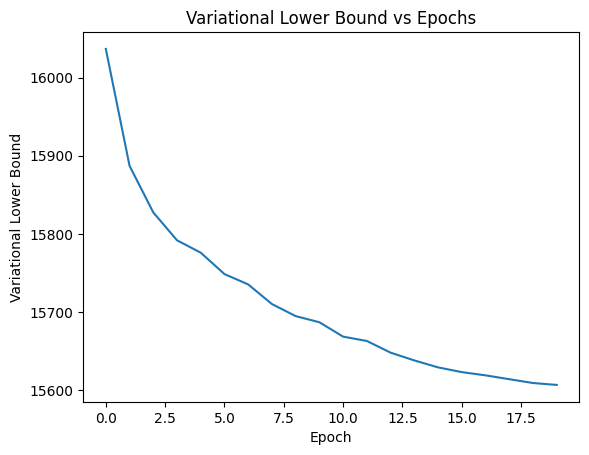

In [ ]:
# Plotting the variational lower bound against epochs
loss = [-value for value in loss_value]

plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Variational Lower Bound')
plt.title('Variational Lower Bound vs Epochs')
plt.show()

In [ ]:
# save loss
np.save('eksamen/loss_VAE4.npy', loss)

In [ ]:
# make new datasets consisting of z (mean, logvar)
# Xtrain is to big to be predicted and downloaded in one go... therefore it is perforemed in steps
Xtrain1 = X_train[:30000]
encoder = model.encoder
Z_Xtrain1 = encoder.predict(Xtrain1)
np.save('eksamen/Z_Xtrain1_VAE4.npy', Z_Xtrain1)

938/938 [==============================] - 2s 3ms/step


In [ ]:
print(Z_Xtrain1.shape)

(30000, 1024)


In [ ]:
# Extract more samples - to big to be extracted at one go
Xtrain2 = X_train[30000:35000]
encoder = model.encoder
Z_Xtrain2 = encoder.predict(Xtrain2)
np.save('eksamen/Z_Xtrain2_VAE4.npy', Z_Xtrain2)

157/157 [==============================] - 1s 3ms/step


In [ ]:
Xtrain3 = X_train[35000:40000]
encoder = model.encoder
Z_Xtrain3 = encoder.predict(Xtrain3)
np.save('eksamen/Z_Xtrain3_VAE4.npy', Z_Xtrain3)

157/157 [==============================] - 0s 3ms/step


In [ ]:
Xtrain4 = X_train[40000:43000]
encoder = model.encoder
Z_Xtrain4 = encoder.predict(Xtrain4)
np.save('eksamen/Z_Xtrain4_VAE4.npy', Z_Xtrain4)

94/94 [==============================] - 0s 2ms/step


In [ ]:
Xtrain5 = X_train[43000:46000]
encoder = model.encoder
Z_Xtrain5 = encoder.predict(Xtrain5)
np.save('eksamen/Z_Xtrain5_VAE4.npy', Z_Xtrain5)

94/94 [==============================] - 0s 3ms/step


In [ ]:
Xtrain6 = X_train[46000:51000]
encoder = model.encoder
Z_Xtrain6 = encoder.predict(Xtrain6)
np.save('eksamen/Z_Xtrain6_VAE4.npy', Z_Xtrain6)

157/157 [==============================] - 0s 2ms/step


In [ ]:
Xtrain7 = X_train[46000:51000]
encoder = model.encoder
Z_Xtrain7 = encoder.predict(Xtrain7)
np.save('eksamen/Z_Xtrain7_VAE4.npy', Z_Xtrain7)

157/157 [==============================] - 0s 3ms/step


In [ ]:
Xtrain8 = X_train[51000:54000]
encoder = model.encoder
Z_Xtrain8 = encoder.predict(Xtrain8)
np.save('eksamen/Z_Xtrain8_VAE4.npy', Z_Xtrain8)

94/94 [==============================] - 0s 3ms/step


In [ ]:
Xtrain9 = X_train[54000:55050]
encoder = model.encoder
Z_Xtrain9 = encoder.predict(Xtrain9)
np.save('eksamen/Z_Xtrain9_VAE4.npy', Z_Xtrain9)

33/33 [==============================] - 0s 5ms/step


In [ ]:
encoder = model.encoder
Z_Xval = encoder.predict(X_val)
np.save('eksamen/Z_Xval_VAE4.npy', Z_Xval)
print(Z_Xval.shape)

492/492 [==============================] - 2s 3ms/step
(15729, 1024)


In [ ]:
encoder = model.encoder
Z_Xtest = encoder.predict(X_test)
np.save('eksamen/Z_Xtest_VAE4.npy', Z_Xtest)
print(Z_Xtest.shape)

246/246 [==============================] - 1s 3ms/step
(7864, 1024)
